<a href="https://colab.research.google.com/github/WayneGretzky1/CSCI-4521-Applied-Machine-Learning/blob/main/4_1_GMMs_and_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example adopted from the *Python Data Science Handbook*: https://jakevdp.github.io/PythonDataScienceHandbook/

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)

Here we use the Handbook's code for plotting GMMs again.

In [3]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        a = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        a = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(xy=position, width=nsig * width, height=nsig * height,
                             angle=a, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=(w * w_factor))

We can use GMMs for generating image data! Here, we use Scikit-Learn's built-in dataset of 8x8 images of handwritten digits.

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [5]:
def plot_digits(data, titles = None, img_size=28, rows=10, _fig_size=(6,6)):
    fig, ax = plt.subplots(rows, 10, figsize=_fig_size,
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          if titles is not None: axi.set_title(titles[i])
        im.set_clim(0, 16)

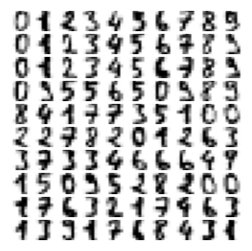

In [6]:
# TODO: draw a set of digits from the dataset
plot_digits(digits.data, img_size=8, _fig_size=(3,3))

Let's use PCA to reduce the dimensionality. We will set `whiten=True`, which provides extra normalization by stretching the data to have approximately the same variance in every direction.

In [7]:
from sklearn.decomposition import PCA
# NOTE: you can set the number of components based on the percent variance explained
# This sets the number of components at whatever explains 99% of variance
pca = PCA(0.99, whiten=True)
data_pca = pca.fit_transform(digits.data)
data_pca.shape # second index is the number of principal components

(1797, 41)

We'll use AIC to figure out a good number of GMM components:

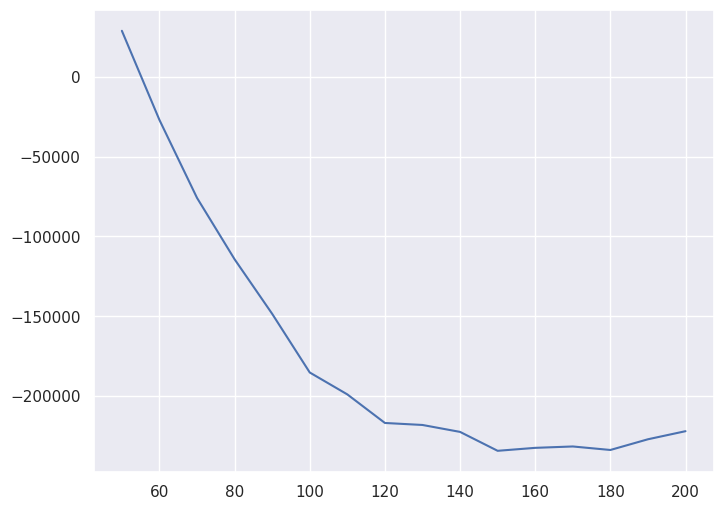

In [8]:
n_components = np.arange(50, 210, 10)
# TODO: Graph the AIC of a model defined by each number of components in n_components
models = [GaussianMixture(n,covariance_type='full', random_state=0) for n in n_components]
aics = [model.fit(data_pca).aic(data_pca) for model in models]
plt.plot(n_components, aics)

It seems that about 140 components is good here. Let's make a 140-component GMM and sample some new digits.

In [9]:
# TODO: create a GMM with the best number of components
gmm = GaussianMixture(150,covariance_type='full', random_state=0)
gmm.fit(data_pca)
print(gmm.converged_)

True


In [10]:
# TODO: sample some new digits
data_new = gmm.sample(100)[0]
data_new.shape

(100, 41)

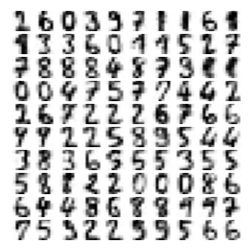

In [11]:
# TODO: graph the new digits
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new, img_size=8, _fig_size=(3,3))

Maybe it's not clear exactly what each of these new digits is meant to be, but I think it's clear that most of them are digits. These are all brand new images, generated by sampling a collection of Gaussians. However, because these Gaussians capture the distribution of the pixel values in the underlying image data space, the resulting samples from the Gaussian mixtures look like meaningful images.

I want to stress that there is no difference between what we did on the two-moons dataset and what we did on the image digit dataset! One dataset is 2D, and the other is 100D, but we can use a GMM to fit a distribution on either dataset, then resample the GMM to generate brand new points (new images!) that could have come from the training data (but didn't).